**ΕΡΓΑΣΙΑ ΠΡΟΗΓΜΕΝΑ ΘΕΜΑΤΑ ΑΝΑΛΥΣΗΣ**

**ΕΔΩ ΚΑΝΩ IMPORT ΤΙΣ ΑΠΑΡΕΤΕΙΤΕΣ ΒΙΒΛΙΟΘΗΚΕΣ ΠΟΥ ΘΑ ΧΡΕΙΑΣΤΩ ΣΤΟΝ ΚΩΔΙΚΑ**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import warnings

**ΕΔΩ ΕΙΣΑΓΩ ΤΟ DATASET ΚΑΙ ΒΛΕΠΩ ΤΙΣ ΛΕΠΤΟΜΕΡΕΙΕΣ ΤΟΥ**

In [2]:
df = pd.read_csv('imdb_master.csv',encoding="latin-1")
df.shape
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  100000 non-null  int64 
 1   type        100000 non-null  object
 2   review      100000 non-null  object
 3   label       100000 non-null  object
 4   file        100000 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
df.groupby(['label'])[['label']].count()

,label
label,
neg,25000
pos,25000
unsup,50000


In [5]:
columns_to_drop = ['Unnamed: 0', 'type', 'file']
for column in columns_to_drop:
    if column in df.columns:
        df = df.drop(column, axis=1)

df.columns = ["review", "label",]
df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


**ΕΔΩ ΑΦΕΡΩ ΑΠΟ ΤΟ DATASET ΟΣΑ REVIEW ΔΕΝ ΕΧΟΥΝ ΞΕΚΑΘΑΡΕΙ ΚΑΤΗΓΟΡΟΠΟΙΗΣΗ ΔΗΛΑΔΗ ΕΙΝΑΙ UNSUP**

In [6]:
df = df[df.label != 'unsup']

In [7]:
df.groupby(['label'])[['label']].count()

,label
label,
neg,25000
pos,25000


In [8]:
print(df.shape)
df.head()

(50000, 2)


,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


**Αντικαθηστώ τα labels με 0 και 1**

In [9]:
df.label.replace({'pos':1,'neg':0},inplace=True)

C:\Users\alfon\AppData\Local\Temp\ipykernel_20752\2002191649.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace({'pos':1,'neg':0},inplace=True)
C:\Users\alfon\AppData\Local\Temp\ipykernel_20752\2002191649.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.label.replace({'pos':1

In [10]:
df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


**Εδώ γίνεται το preprocess των reviews**

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english')) # Δημιουργεί ένα σύνολο (set) από stop words στα Αγγλικά.

def process(review):
    review = BeautifulSoup(review).get_text() #αφαιρούνται όλα τα HTML tags (π.χ., <br>, <p>)
    review = review.lower()#ολο το κείμενο μετατρέπεται σε πεζά για ομοιομορφία
    review = re.sub("[^a-zA-Z]",' ',review)# Αφαιρεί χαρακτήρες που δεν είναι γράμματα όπως αριθμούς ,σημεία στίξης
    review = re.sub(r"https\S+|www\S+|http\S+", '', review, flags = re.MULTILINE) # Αφαιρεί URLs.
    review = re.sub(r'\@w+|\#', '', review) # Αφαιρεί τα @ και τα #.
    review = re.sub(r'[^\w\s]', '', review)# Αφαιρεί χαρακτήρες εκτός από γράμματα και κενά .
    review_tokens = word_tokenize(review) # Διαχωρίζει το κείμενο σε ένα πίνακα από λέξεις
    filtered_review = [w for w in review_tokens if not w in stop_words] # Αφαιρεί τα stopwords
    return " ".join(filtered_review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alfon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Εφαρμόζουμε το Process στα reviews**

In [12]:
df.review = df['review'].apply(process)

C:\Users\alfon\AppData\Local\Temp\ipykernel_20752\2299322948.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review).get_text() #αφαιρούνται όλα τα HTML tags (π.χ., <br>, <p>)


In [13]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count
df['word_count'] = df['review'].apply(no_of_words)
df.head(10)

,review,label,word_count
0,mr costner dragged movie far longer necessary ...,0,73
1,example majority action films generic boring r...,0,126
2,first hate moronic rappers could nt act gun pr...,0,110
3,even beatles could write songs everyone liked ...,0,164
4,brass pictures movies fitting word really some...,0,139
5,funny thing happened watching mosquito one han...,0,55
6,german horror film one weirdest seen aware con...,0,76
7,long time fan japanese film expected really bo...,0,70
8,tokyo eyes tells year old japanese girl falls ...,0,72
9,wealthy horse ranchers buenos aires long stand...,0,99


**ΒΛΕΠΟΥΜΕ ΤΑ DUPLICATES ENTRIES ΚΑΙ ΤΑ ΑΦΑΙΡΟΥΜΕ ΑΠΟ ΤΟ DATASET**

In [14]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  425


In [15]:
df = df.drop_duplicates('review')

In [16]:
print(df.shape)

(49575, 3)


In [17]:
columns_to_drop = ['word_count']
for column in columns_to_drop:
    if column in df.columns:
        df = df.drop(column, axis=1)

print(df.shape)
df.head()

(49575, 2)


,review,label
0,mr costner dragged movie far longer necessary ...,0
1,example majority action films generic boring r...,0
2,first hate moronic rappers could nt act gun pr...,0
3,even beatles could write songs everyone liked ...,0
4,brass pictures movies fitting word really some...,0


In [18]:
X = df['review']
Y = df['label']

**XRHSIMOPOIOYME TO TfidfVectorizer GIA NA METATREPSOYME TA REVIEWS SE VECTORS**

In [19]:
vect = TfidfVectorizer()
X = vect.fit_transform(df['review'])

**ΧΩΡΙΖΟΥΜΕ ΤΟ DATASET ΓΙΑ ΤΗΝ ΕΚΠΑΙΔΕΥΣΗ**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)


In [21]:
print("Size of x_train: ", (X_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (X_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (34702, 101201)
Size of y_train:  (34702,)
Size of x_test:  (14873, 101201)
Size of y_test:  (14873,)


**ΕΚΠΑΙΔΕΥΩ ΤΟ SVM ΜΟΝΤΕΛΟ ΧΡΗΣΙΜΟΠΟΙΩΝΤΑΣ ΤΟΝ ΑΛΓΟΡΙΘΜΟ LINEARSVC() ΠΟΥ ΧΡΗΣΙΜΟΠΟΙΕΙ ΓΡΑΜΜΙΚΟΥΣ ΔΙΑΧΩΡΙΣΤΕΣ ΓΙΑ ΤΗΝ ΚΑΤΗΓΟΡΙΟΠΟΙΗΣΗ**

In [22]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)


LinearSVC()

**ΤΑ ΑΠΟΤΕΛΕΣΜΑΤΑ ΤΗΣ ΕΚΠΑΙΔΕΥΣΗΣ**

In [23]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_svm = svm_model.predict(X_test)
print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")

SVM Performance:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7358
           1       0.89      0.91      0.90      7515

    accuracy                           0.90     14873
   macro avg       0.90      0.90      0.90     14873
weighted avg       0.90      0.90      0.90     14873

SVM Accuracy: 89.63%


**Η ΕΚΠΑΙΔΕΥΣΗ ΤΟΥ ΝΝ ΜΟΝΤΕΛΟΥ , ΧΡΗΣΙΜΟΠΟΙΗΣΑ 5 ΕΠΟΧΕΣ ΚΑΙ ΕΝΑ EARLY STOP ΓΙΑ ΝΑ ΑΠΟΦΥΓΩ ΤΟ OVERFITTING**

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

nn_model = Sequential([
    Dense(40, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(20, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = nn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print("NN Accuracy: ", nn_accuracy)


C:\Users\alfon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 78s 70ms/step - accuracy: 0.7907 - loss: 0.4646 - val_accuracy: 0.9021 - val_loss: 0.2470
Epoch 2/5
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9550 - loss: 0.1456 - val_accuracy: 0.8991 - val_loss: 0.2693
Epoch 3/5
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.9800 - loss: 0.0715 - val_accuracy: 0.8922 - val_loss: 0.3330
NN Accuracy:  0.8921535611152649


In [27]:

from sklearn.metrics import classification_report, accuracy_score

y_pred_nn = (nn_model.predict(X_test) > 0.5).astype("int32")

print("NN Performance:")
print(classification_report(y_test, y_pred_nn))
print(f"NN Accuracy: {accuracy_score(y_test, y_pred_nn) * 100:.2f}%")

465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
NN Performance:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7358
           1       0.88      0.91      0.89      7515

    accuracy                           0.89     14873
   macro avg       0.89      0.89      0.89     14873
weighted avg       0.89      0.89      0.89     14873

NN Accuracy: 89.22%


**ΔΙΑΓΡΑΜΜΑΤΑ ΓΙΑ ΤΑ ΑΠΟΤΕΛΕΣΜΑΤΑ ΤΗΣ ΕΚΠΑΙΔΕΥΣΗΣ**

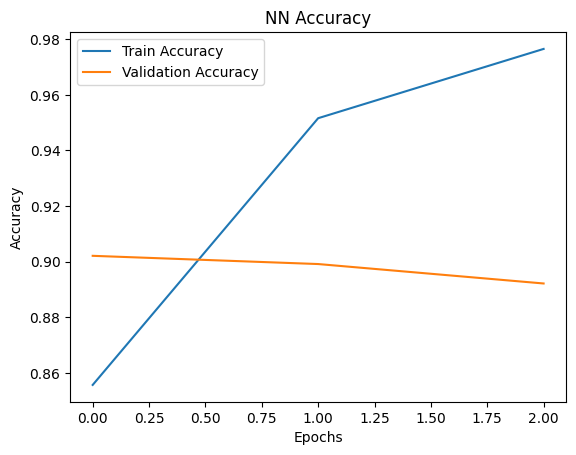

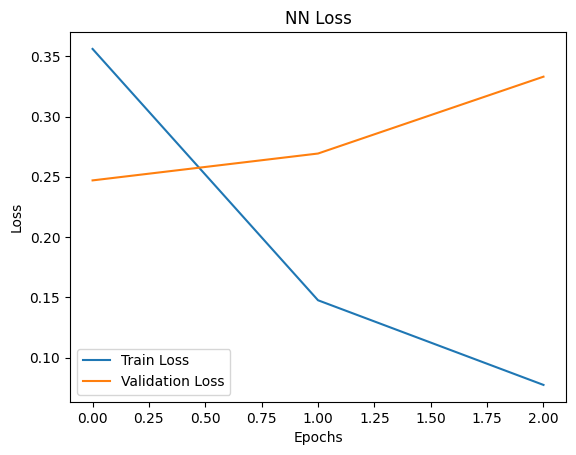

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**ΑΠΟΘΗΚΕΥΣΗ ΤΩΝ ΜΟΝΤΕΛΩΝ**

In [26]:
import pickle
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

nn_model.save('nn_model.h5')

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vect, file)